In [1]:
from src.models import Exponential_Model
from src.criterion import RightCensorWrapper,RankingWrapper,RHC_Ranking_Wrapper
from src.load_data import load_datasets,load_dataframe
from src.utils import train_robust,lower_bound
from src.visualizations import *
from src.metrics import concordance

from torch.optim import Adam
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter,CoxPHFitter,ExponentialFitter
from lifelines.utils import concordance_index

from auto_LiRPA import BoundedModule, BoundedTensor

from tqdm import tqdm
import pandas as pd
import numpy as np
from copy import deepcopy
import random
# set seeds for random!!!
torch.manual_seed(123)
random.seed(123)
np.random.seed(123)
torch.cuda.manual_seed_all(123)


C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\utils\cpp_extension.py:23: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]
C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\visualizations.py:145: DeprecationWarning: invalid escape sequence '\m'
  axes[0].set_title("$\mu$={:.4f} $\sigma^2$={:.4f}".format(lambda_robust.mean(),lambda_robust.var()))
C:\Users\lpott\OneDrive\Documents\Northeastern University\Classes\EECE 7398 Verifiable Machine Learning\EECE7398_Final_Project\src\visualizations.py:148: D

In [2]:
class ARGS(object):
    def __init__(self):
        pass

In [3]:
def loss_wrapper(loss_wrapper):
    if loss_wrapper == "rank":
        return RankingWrapper
    elif loss_wrapper == "rhc":
        return RightCensorWrapper
    elif loss_wrapper == "rhc_rank":
        return RHC_Ranking_Wrapper
    else:
        raise Exception("not valid wrapper choice")

In [4]:
args = ARGS()
args.verify=False
args.device="cpu"

args.seed = 123

args.eps=0.5
args.norm=np.inf
args.bound_type = "CROWN-IBP"
args.num_epochs=150
args.lr = 1e-3
args.batch_size= 256
args.scheduler_name = "SmoothedScheduler"
args.scheduler_opts = "start=100,length=10"
args.hidden_dims = [50,50]
args.pareto = [0.1,0.9]
args.save_model = ""
args.dataset = "Framingham"
args.loss_wrapper="rhc_rank"
args.weight = 1.0
args.sigma = 1.0

In [5]:
# GOOD DATASETS
# 1. TRACE
# 2. divorce 
# 3. Dialysis
# 3. Aids2
# 5. Framingham
# 6. rott2
# 7. dataDIVAT1
# 8. prostate
dataset_train,dataset_test = load_datasets(args.dataset,test_size=0.2)

In [6]:
input_dims = dataset_train.tensors[0].shape[1]
output_dim = 1

In [7]:
dataloader_train = DataLoader(dataset_train,batch_size=args.batch_size,shuffle=True)
dataloader_test = DataLoader(dataset_test,batch_size=args.batch_size,shuffle=False)

dataloader_train.mean = dataloader_test.mean = dataset_train.mean
dataloader_train.std = dataloader_test.std = dataset_train.std


dataset_train.tensors[0].shape

torch.Size([3726, 19])

In [8]:
clf_robust = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile = Exponential_Model(input_dim=input_dims,hidden_layers=args.hidden_dims)
clf_fragile.load_state_dict(deepcopy(clf_robust.state_dict()))

wrapper = loss_wrapper(args.loss_wrapper)

# # model = BoundedModule(clf, X_train)
model_robust_wrap = BoundedModule(wrapper(clf_robust,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)
model_fragile_wrap = BoundedModule(wrapper(clf_fragile,weight=args.weight,sigma=args.sigma),dataloader_train.dataset.tensors)

In [9]:
train_robust(model_robust_wrap,dataloader_train,dataloader_test,method="robust",args=args)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\torch\optim\lr_scheduler.py:371: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=5537.7646 Time=0.0355
[ 1:  10]: eps=0.00000000 Loss=4605.3910 Time=0.0118
[ 1:  14]: eps=0.00000000 Loss=4312.6764 Time=0.0110
Epoch time: 0.1856, Total time: 0.1856
Evaluating...
[ 1:   3]: eps=0.00000000 Loss=3191.4716 Time=0.0056
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=3416.8169 Time=0.0116
[ 2:  10]: eps=0.00000000 Loss=2885.9921 Time=0.0094
[ 2:  14]: eps=0.00000000 Loss=2666.6380 Time=0.0092
Epoch time: 0.1546, Total time: 0.3402
Evaluating...
[ 2:   3]: eps=0.00000000 Loss=1841.9776 Time=0.0053
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=1928.8315 Time=0.0093
[ 3:  10]: eps=0.00000000 Loss=1601.3865 Time=0.0094
[ 3:  14]: eps=0.00000000 Loss=1465.4079 Time=0.0093
Epoch time: 0.1582, Total time: 0.4984
Evaluating...
[ 3:   3]: eps=0.00000000 Loss=976.3378 Time=0.0050
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=1042.5067 Time=0.0090
[ 4:  10]: eps=0.00000000 Los

In [10]:
train_robust(model_fragile_wrap,dataloader_train,dataloader_test,method="natural",args=args)

Epoch 1, learning rate [0.001]
[ 1:   0]: eps=0.00000000 Loss=5537.7646 Time=0.0520
[ 1:  10]: eps=0.00000000 Loss=4605.3910 Time=0.0162
[ 1:  14]: eps=0.00000000 Loss=4312.6764 Time=0.0147
Epoch time: 0.2531, Total time: 0.2531
Evaluating...
[ 1:   3]: eps=0.00000000 Loss=3191.4716 Time=0.0061
Epoch 2, learning rate [0.001]
[ 2:   0]: eps=0.00000000 Loss=3416.8169 Time=0.0120
[ 2:  10]: eps=0.00000000 Loss=2885.9921 Time=0.0127
[ 2:  14]: eps=0.00000000 Loss=2666.6380 Time=0.0125
Epoch time: 0.2181, Total time: 0.4712
Evaluating...
[ 2:   3]: eps=0.00000000 Loss=1841.9776 Time=0.0060
Epoch 3, learning rate [0.001]
[ 3:   0]: eps=0.00000000 Loss=1928.8315 Time=0.0100
[ 3:  10]: eps=0.00000000 Loss=1601.3865 Time=0.0108
[ 3:  14]: eps=0.00000000 Loss=1465.4079 Time=0.0115
Epoch time: 0.1997, Total time: 0.6709
Evaluating...
[ 3:   3]: eps=0.00000000 Loss=976.3378 Time=0.0075
Epoch 4, learning rate [0.001]
[ 4:   0]: eps=0.00000000 Loss=1042.5067 Time=0.0115
[ 4:  10]: eps=0.00000000 Los

In [11]:
X_train,T_train,E_train = dataloader_train.dataset.tensors
t = torch.linspace(0,T_train.max(),10000)

In [12]:
clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())

<lifelines.ExponentialFitter:"Exponential_estimate", fitted with 3726 total observations, 2554 right-censored observations>

<>:20: DeprecationWarning: invalid escape sequence '\l'
C:\Users\lpott\AppData\Local\Temp\ipykernel_1916\671205530.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])


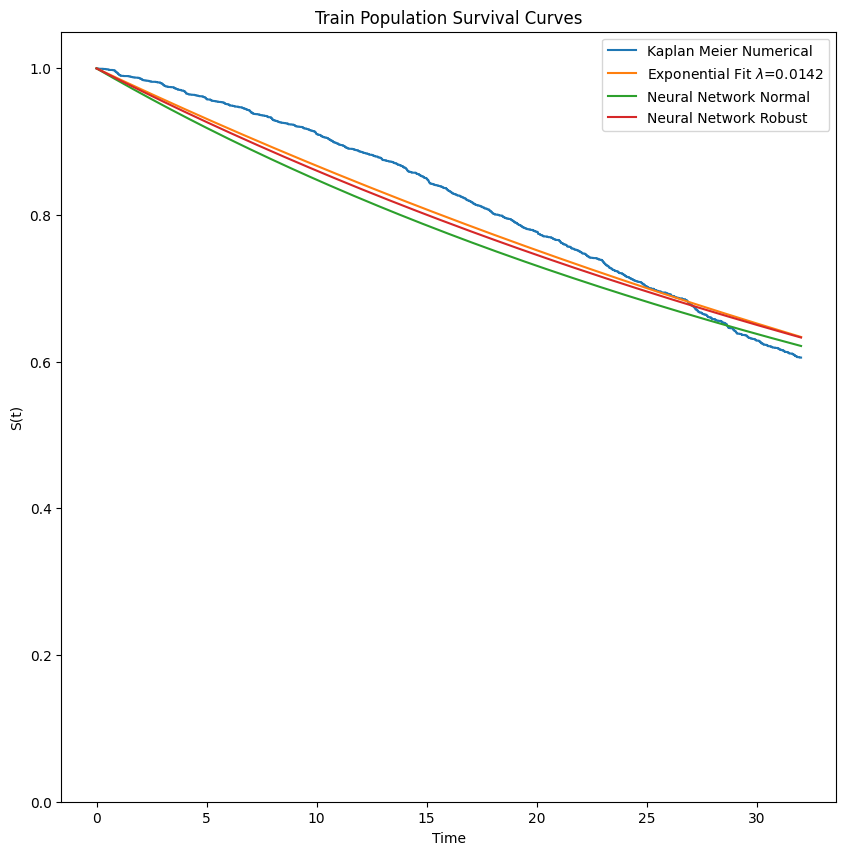

In [13]:
St_robust_x = clf_robust.survival_qdf(X_train,t).detach()
St_fragile_x = clf_fragile.survival_qdf(X_train,t).detach()

kmf = KaplanMeierFitter()
kmf.fit(durations=T_train,event_observed=E_train)
St_kmf  = kmf.predict(times=t.ravel().numpy())

clf_exp = ExponentialFitter()
clf_exp.fit(durations=T_train.ravel(),event_observed=E_train.ravel())
St_exp = clf_exp.predict(times=t.ravel().numpy())

plt.figure(figsize=(10,10))
plt.plot(t,St_kmf)
plt.plot(t,St_exp)
plt.plot(t,St_fragile_x.mean(0))

plt.plot(t,St_robust_x.mean(0))

plt.ylabel("S(t)"); plt.xlabel("Time")
plt.legend(["Kaplan Meier Numerical",f"Exponential Fit $\lambda$={np.round(1/clf_exp.params_[0],4)}","Neural Network Normal","Neural Network Robust"])
plt.title("Train Population Survival Curves")
plt.ylim([0,1.05])
plt.show()

In [14]:
print("Exponential rate parameters: ",1/clf_exp.params_.item())

Exponential rate parameters:  0.014243746090981868


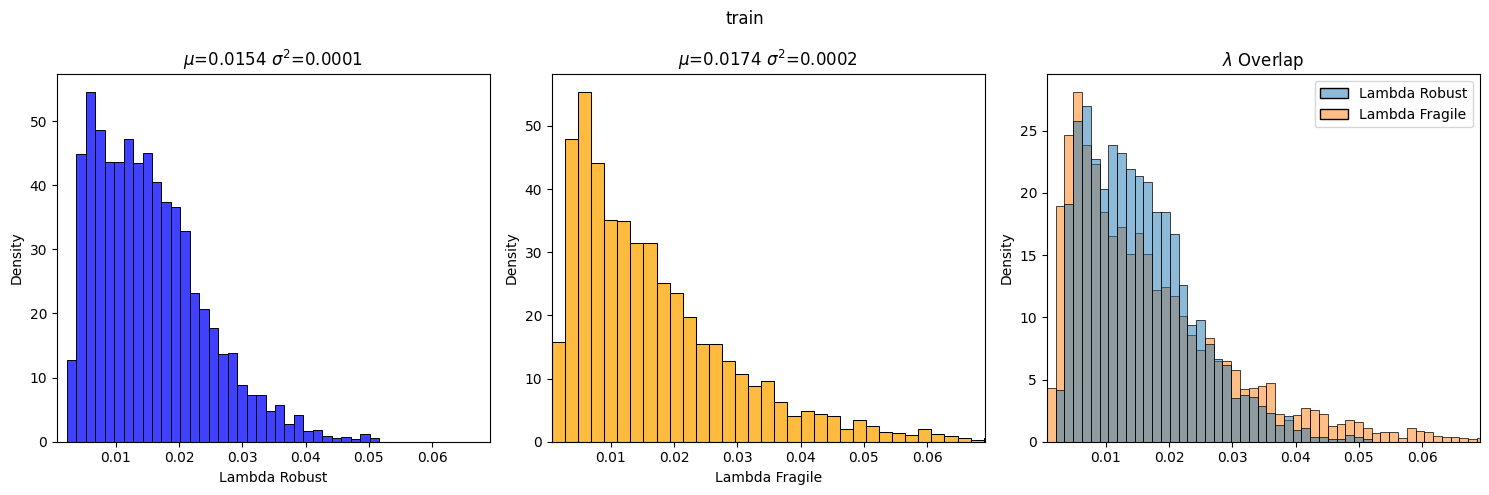

In [15]:
visualize_individual_lambda_histograms(clf_fragile,clf_robust,dataloader_train,suptitle="train")

torch.Size([3726, 1000])


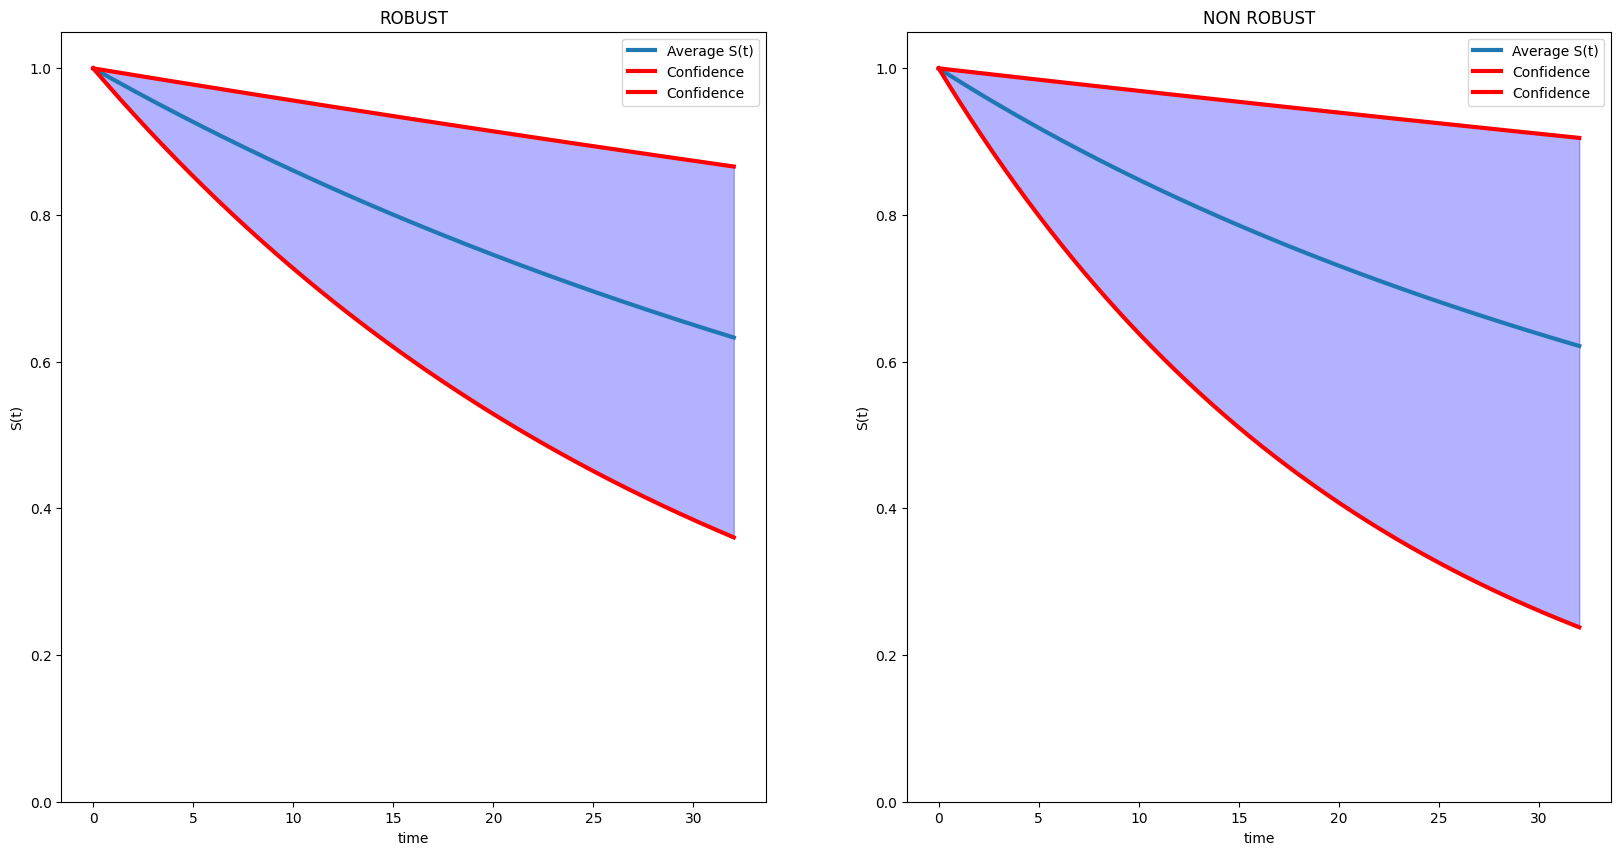

In [16]:
visualize_curve_distributions(clf_fragile,clf_robust,dataloader_train)

C:\Users\lpott\anaconda3\envs\survival\lib\site-packages\lifelines\fitters\kaplan_meier_fitter.py:444: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


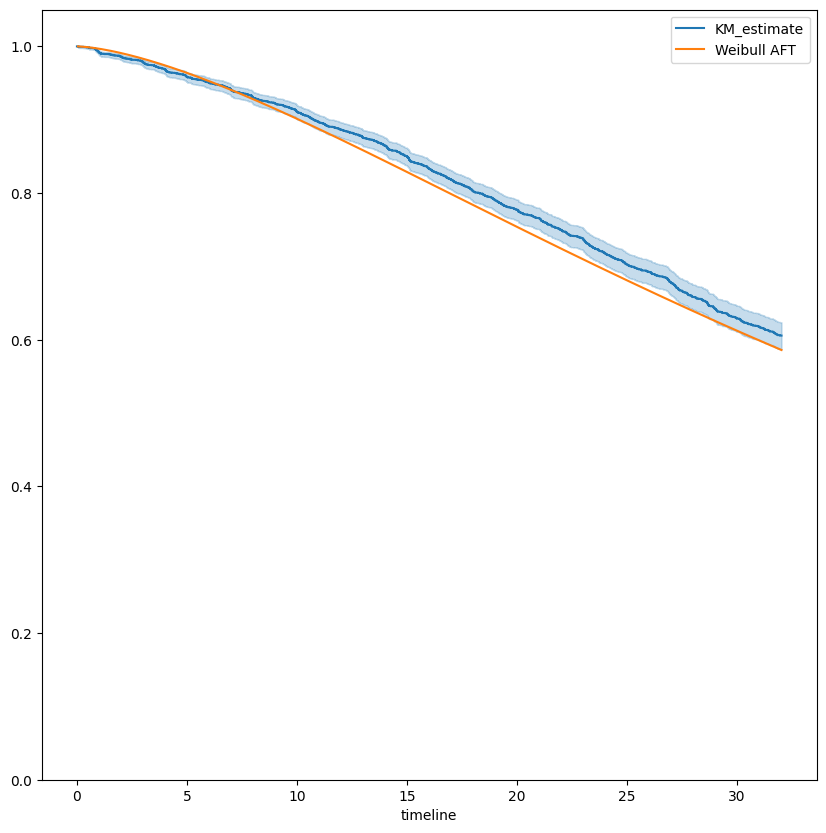

param    covariate   
lambda_  fac_month_10   -0.019687
         fac_month_11   -0.005628
         fac_month_12    0.021224
         fac_month_2    -0.031393
         fac_month_3    -0.009205
         fac_month_4    -0.023353
         fac_month_5    -0.026619
         fac_month_6     0.001821
         fac_month_7     0.004053
         fac_month_8    -0.022439
         fac_month_9    -0.017847
         fac_sex_M      -0.250027
         num_age        -0.210150
         num_bmi        -0.086104
         num_dbp        -0.043317
         num_sbp        -0.155843
         num_scl        -0.173198
         Intercept       3.955227
rho_     Intercept       0.427737
dtype: float64


In [17]:
df_train,df_test = load_dataframe(ds_name=args.dataset,drop_first=True)
from lifelines import WeibullAFTFitter
clf_cph = WeibullAFTFitter()
# clf_cph._scipy_fit_method = "SLSQP"
clf_cph.fit(df=df_train,duration_col="time",event_col="event")
kmf.plot()
clf_cph.predict_survival_function(df_train).mean(1).plot(label="Weibull AFT",figsize=(10,10))
plt.legend()
plt.ylim([0,1.05])
plt.show()
print(clf_cph.params_)

In [18]:
print("Lifelines CPH Train CI: {:.3f}".format(clf_cph.score(df_train,scoring_method="concordance_index")))
print("Lifelines CPH Test CI: {:.3f}".format(clf_cph.score(df_test,scoring_method="concordance_index")))

# F_tr = 1-clf_exp.survival_function_at_times(times=T_train.ravel().numpy())
# exp_ci_tr = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())
# exp_ci_te = concordance_index(event_times=T_train.ravel(),predicted_scores=F_tr,event_observed=E_train.ravel())

# print("Lifelines EXP Train CI: {:.3f}".format(exp_ci_tr))
# print("Lifelines EXP Test CI: {:.3f}".format(exp_ci_te))

Lifelines CPH Train CI: 0.714
Lifelines CPH Test CI: 0.720


ROBUST CLF
CI @ eps=10 0.3485454487965692
CI @ eps=5 0.36133012263128905
CI @ eps=2 0.4925091569910153
CI @ eps=1 0.6868134336927345
CI @ eps=0.8 0.7032462594045334
CI @ eps=0.7 0.7079070471803457
CI @ eps=0.6 0.7109739111043806
CI @ eps=0.5 0.7125605126916478
CI @ eps=0.1 0.7116225971739387
CI @ eps=0.07 0.7112872707423944
CI @ eps=0.05 0.7111291763950162
CI @ eps=0 0.7105365722150017
NONROBUST CLF
CI @ eps=10 0.4962298658527859
CI @ eps=5 0.4557240970732576
CI @ eps=2 0.5439760229120313
CI @ eps=1 0.6614554332034741
CI @ eps=0.8 0.686639696325721
CI @ eps=0.7 0.6968346183352832
CI @ eps=0.6 0.7057747704719699
CI @ eps=0.5 0.7131389715879496
CI @ eps=0.1 0.7311963415303866
CI @ eps=0.07 0.7316569785341159
CI @ eps=0.05 0.731879808356368
CI @ eps=0 0.7323772230977506


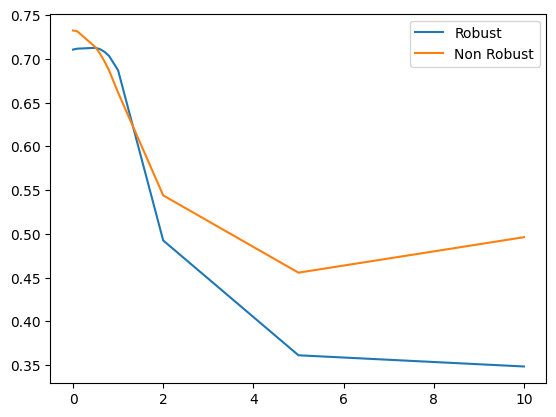

In [19]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_train,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_train,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

ROBUST CLF
CI @ eps=10 0.3345822243576939
CI @ eps=5 0.35585296197720684
CI @ eps=2 0.48688394491202874
CI @ eps=1 0.6865643439812991
CI @ eps=0.8 0.7036889073643181
CI @ eps=0.7 0.7085854959483023
CI @ eps=0.6 0.7112740308047789
CI @ eps=0.5 0.7130231980607997
CI @ eps=0.1 0.711808498577452
CI @ eps=0.07 0.7114899773795963
CI @ eps=0.05 0.7111336655311475
CI @ eps=0 0.7102968725537302
NONROBUST CLF
CI @ eps=10 0.4881823236931183
CI @ eps=5 0.4248155006451404
CI @ eps=2 0.5170732760714999
CI @ eps=1 0.6242961491327046
CI @ eps=0.8 0.6509655511226523
CI @ eps=0.7 0.6622433609924905
CI @ eps=0.6 0.6709783999438539
CI @ eps=0.5 0.6805340358795234
CI @ eps=0.1 0.6992835972380433
CI @ eps=0.07 0.6997964703532346
CI @ eps=0.05 0.6996291117577511
CI @ eps=0 0.6999962209349407


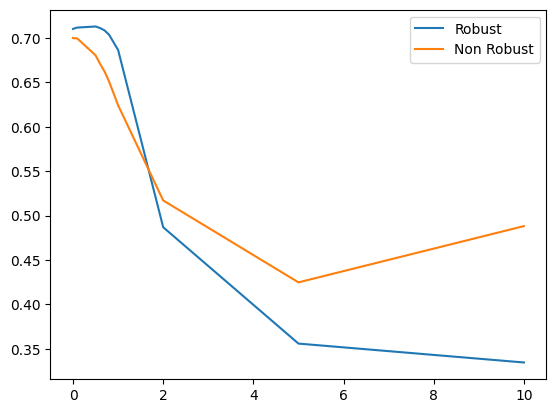

In [20]:
epsilons = [10,5,2,1,.8,0.7,.6,0.5,0.1,0.07,0.05,0]
print("ROBUST CLF")
eps_,ci_ = concordance(clf_robust,dataloader_test,epsilons)
plt.figure()
plt.plot(eps_,ci_)
print("NONROBUST CLF")
eps_,ci_ = concordance(clf_fragile,dataloader_test,epsilons)
plt.plot(eps_,ci_)
plt.legend(["Robust","Non Robust"])

<Figure size 1000x1000 with 0 Axes>

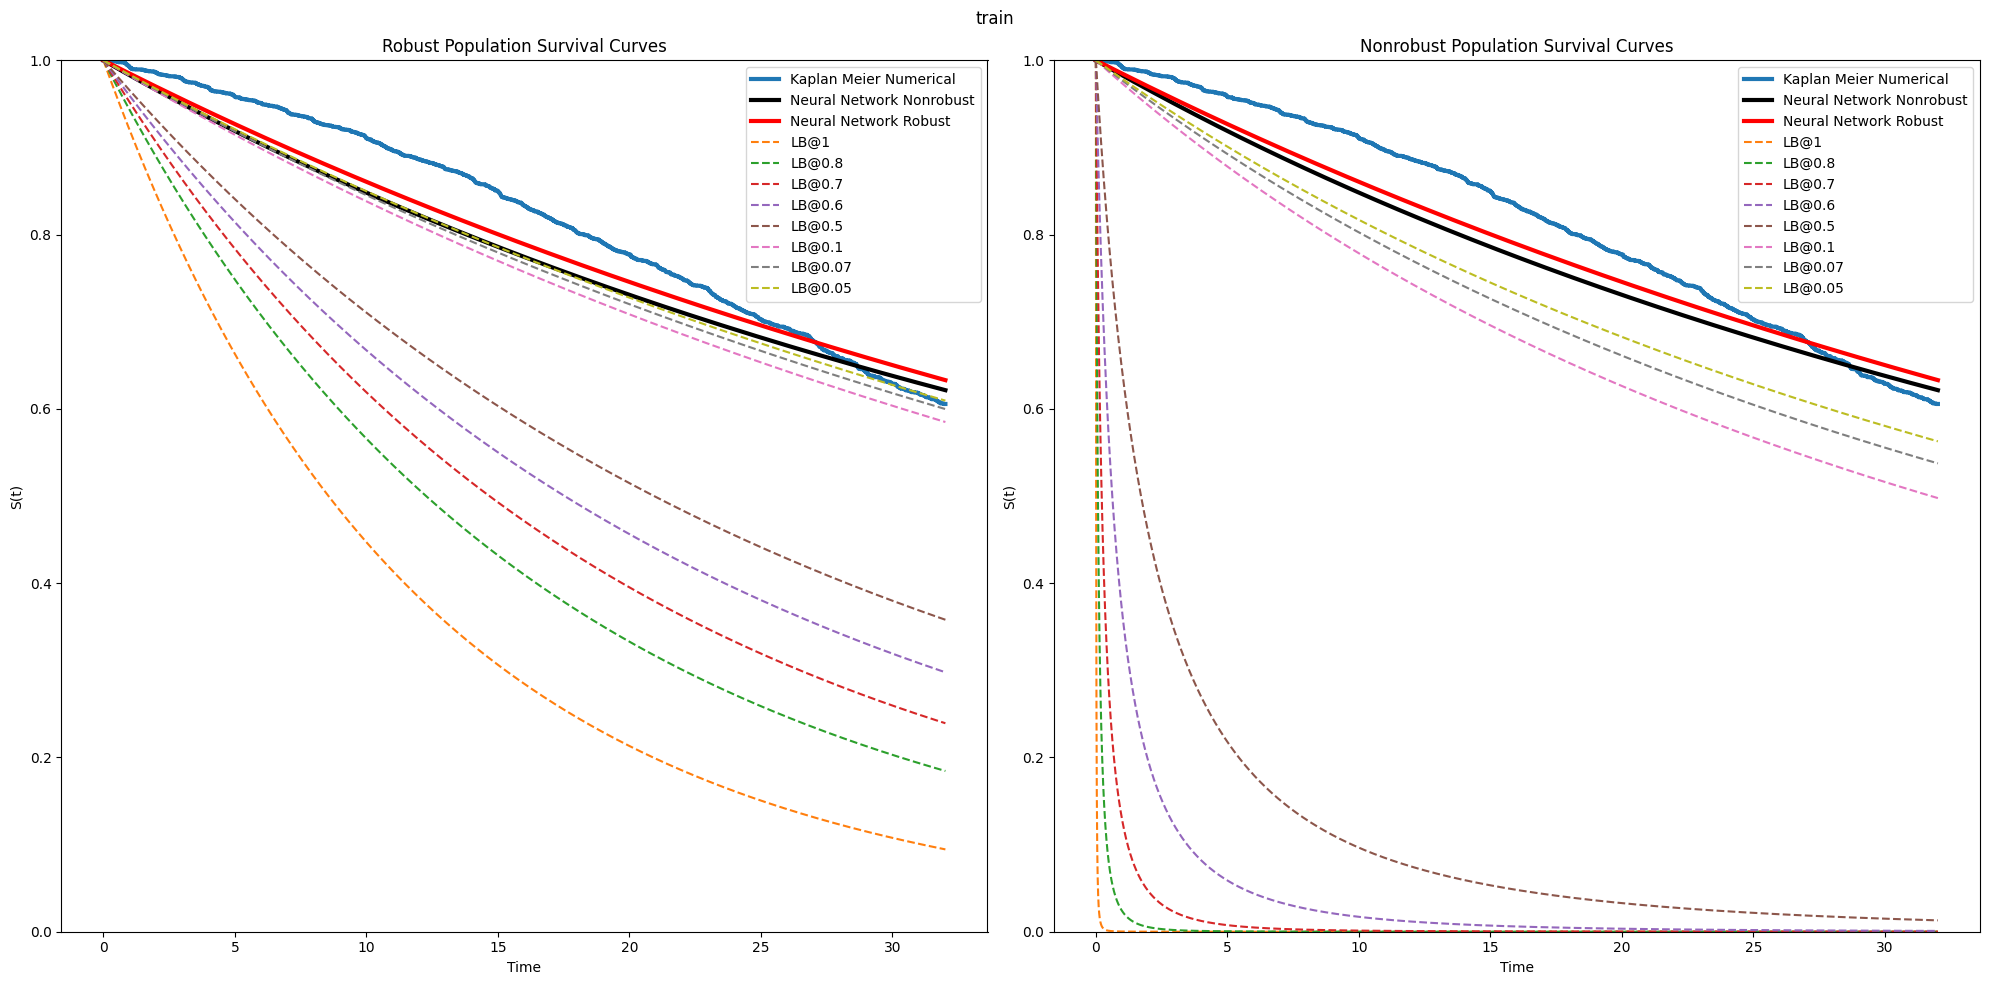

<Figure size 1000x1000 with 0 Axes>

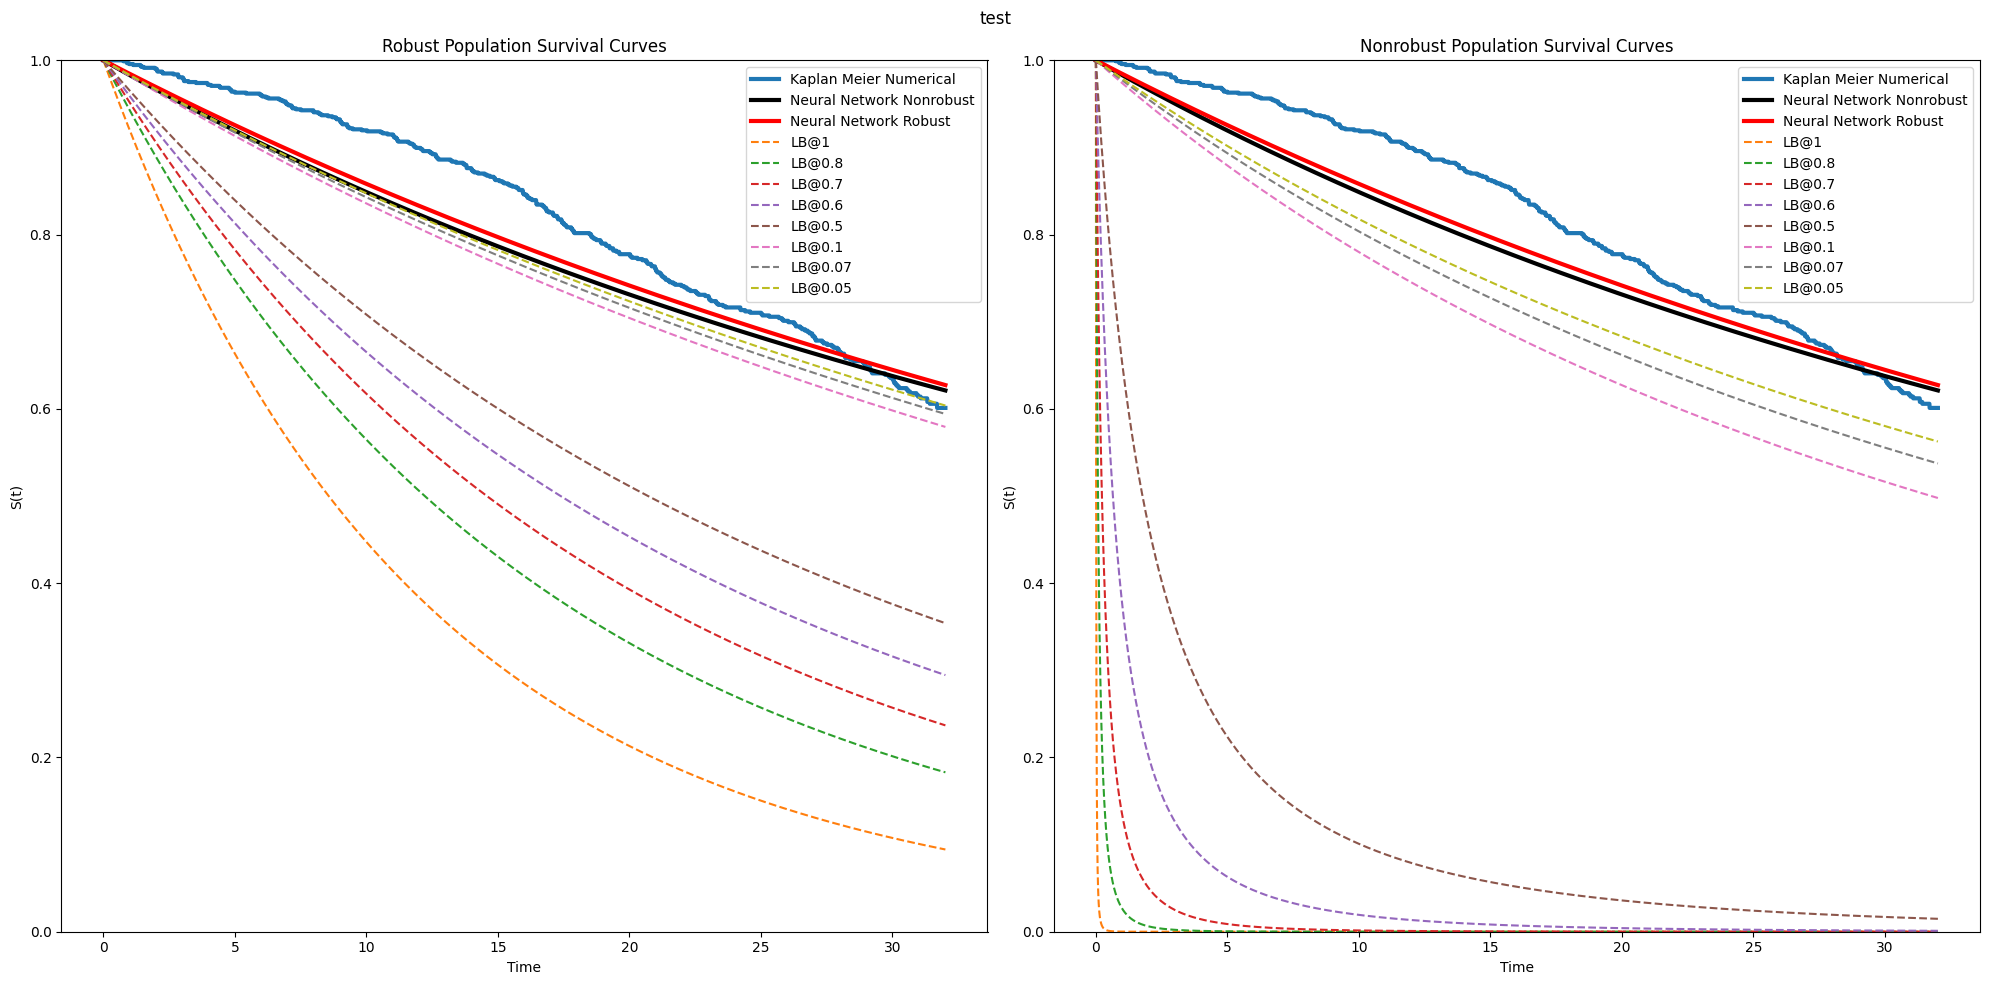

In [21]:
epsilons = [1,.8,0.7,.6,0.5,0.1,0.07,0.05]
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_train,epsilons=epsilons,suptitle="train")
visualize_population_curves_attacked(clf_fragile,clf_robust,dataloader_test,epsilons=epsilons,suptitle="test")

tensor([0.0030, 0.0047, 0.0079, 0.0094, 0.0110, 0.0120, 0.0130, 0.0132, 0.0139,
        0.0153])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.18it/s]


tensor([35.2817, 31.6592, 30.9777, 30.8485, 30.2833, 30.1019, 29.7672, 29.6371,
        29.3920, 28.9961])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.11it/s]


tensor([0.0249, 0.0259, 0.0292, 0.0325, 0.0370, 0.0417, 0.0423, 0.0432, 0.0623,
        0.0726])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.13it/s]


tensor([26.4797, 26.3448, 24.6639, 22.7412, 21.6784, 21.6774, 20.9237, 20.8569,
        20.1433, 19.7056])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.07it/s]


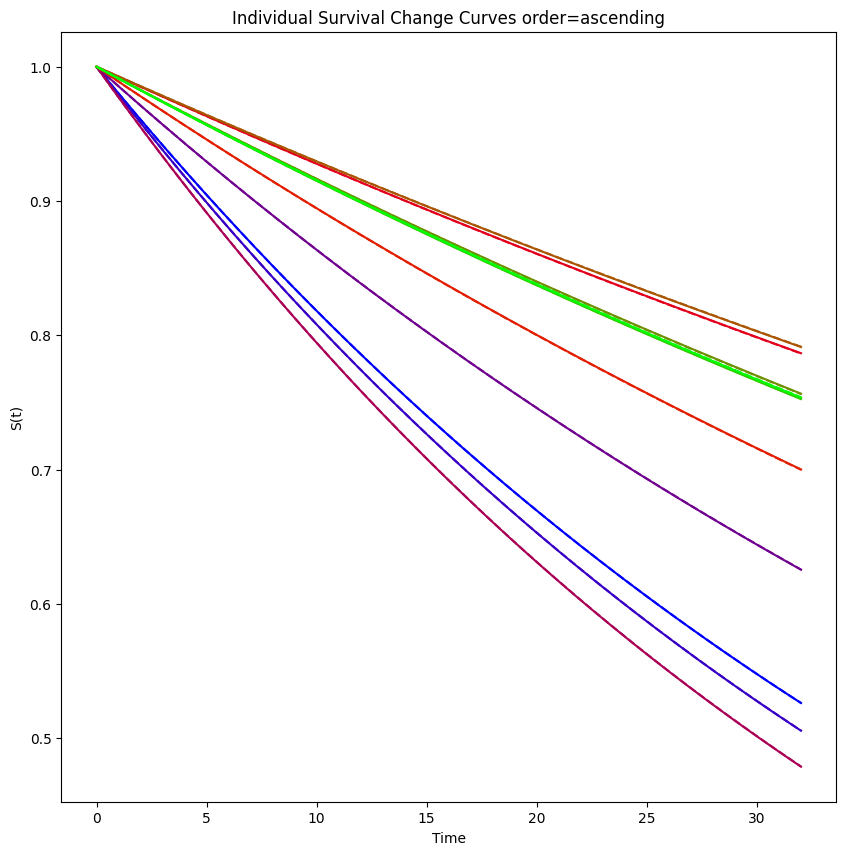

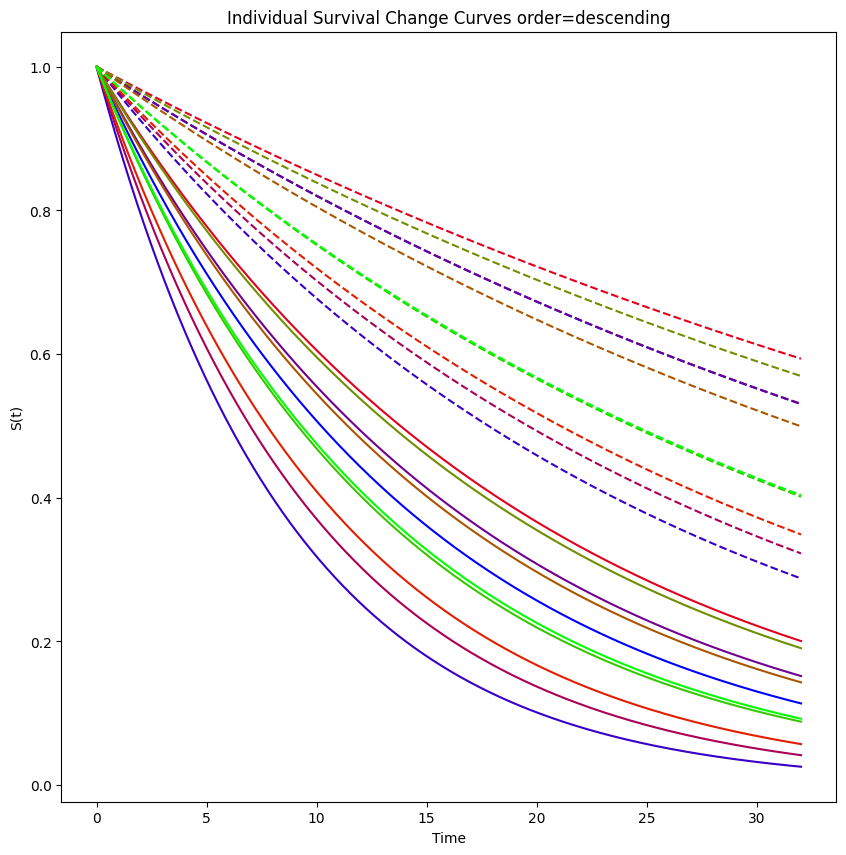

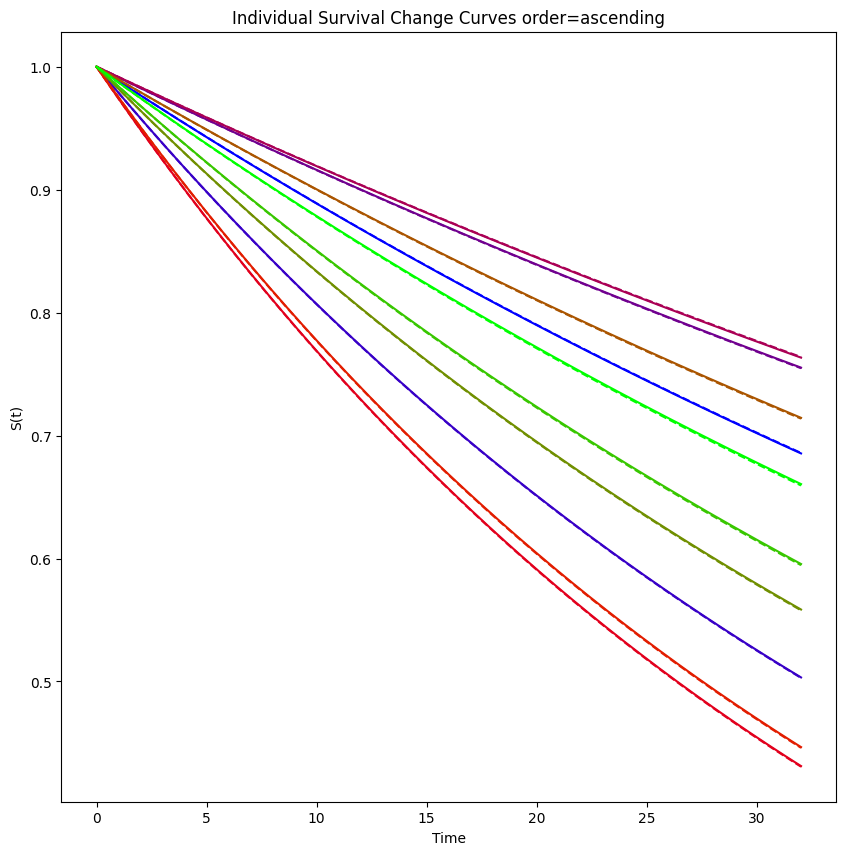

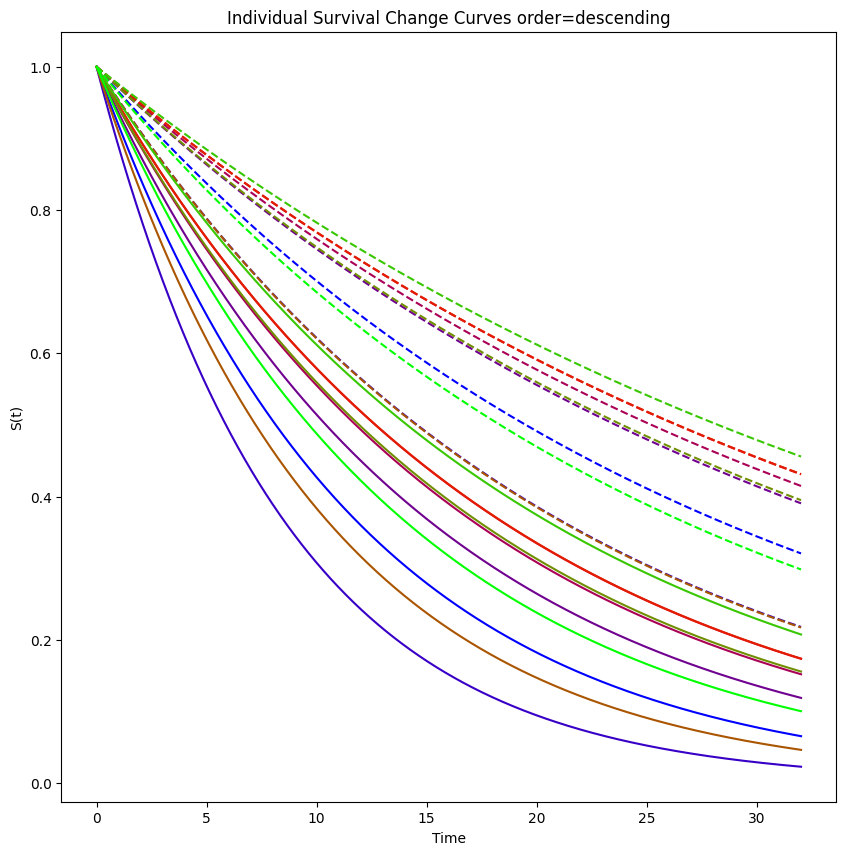

In [22]:
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_train,order="descending",test_cases=10)

visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="ascending",test_cases=10)
visualize_individual_curves_changes(clf_robust,clf_fragile,dataloader_test,order="descending",test_cases=10)

tensor([16.7926, 16.7374, 16.4998, 16.2393, 16.1616, 16.0807, 15.9607, 15.8594,
        15.8415, 15.8412])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.16it/s]


tensor([3.5182, 3.9317, 4.0442, 4.1582, 4.2218, 4.2249, 4.2266, 4.2747, 4.3119,
        4.5397])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.21it/s]


tensor([16.9638, 16.6269, 15.7959, 15.6390, 15.6360, 15.5596, 15.4664, 15.4660,
        15.4514, 15.4210])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.03it/s]


tensor([4.3170, 4.5302, 4.7537, 4.8178, 4.8419, 5.1817, 5.2254, 5.2885, 5.3049,
        5.3922])


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.06it/s]


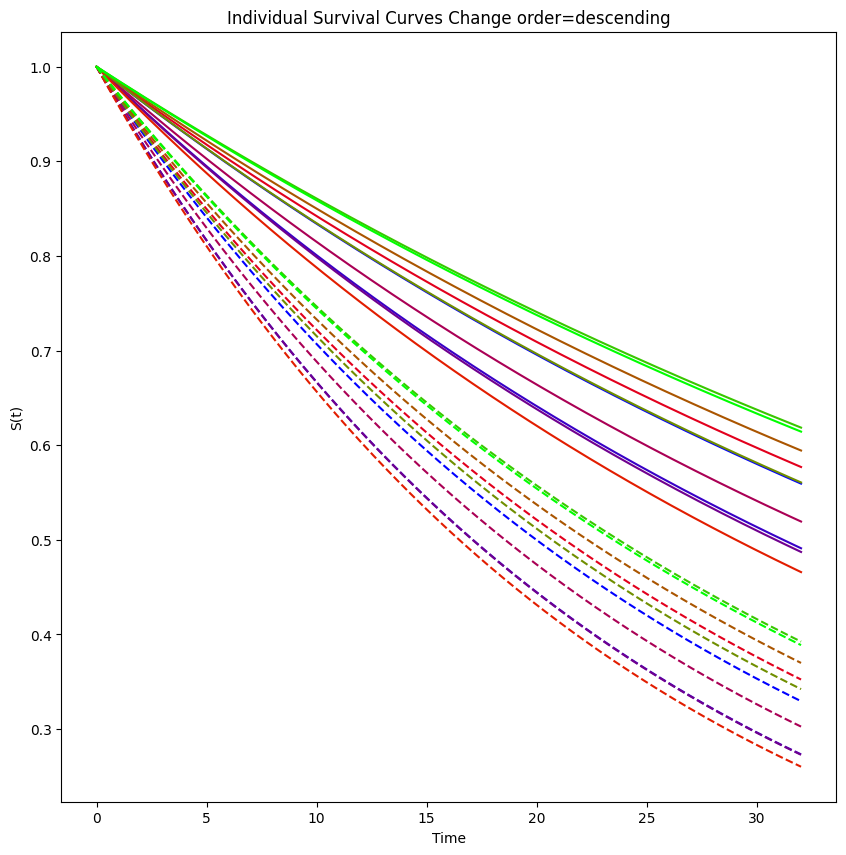

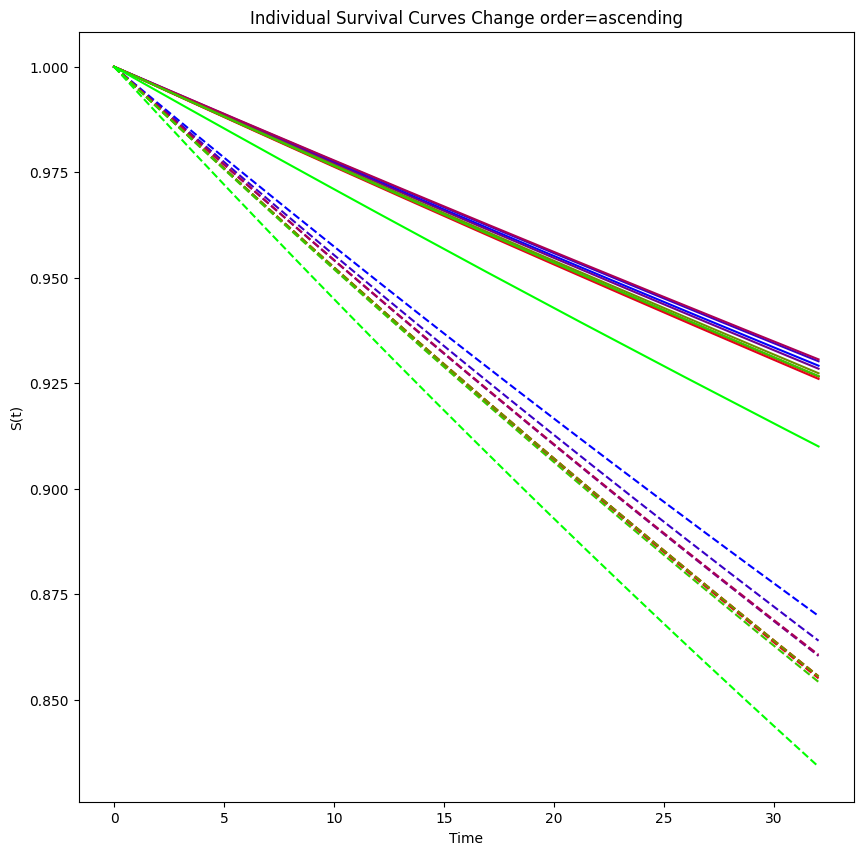

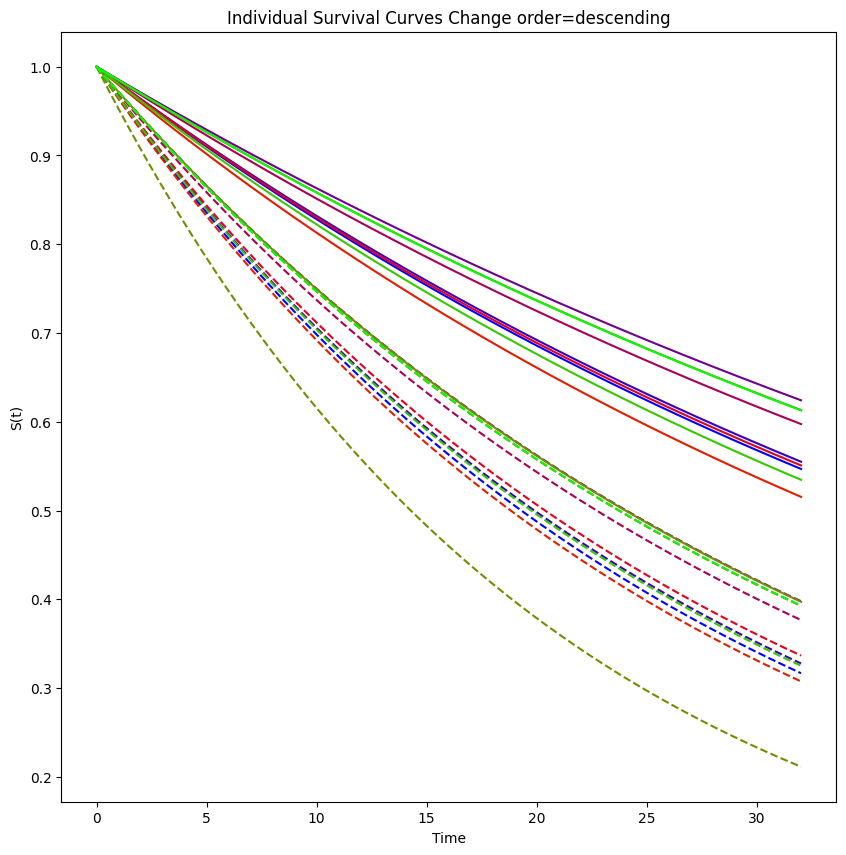

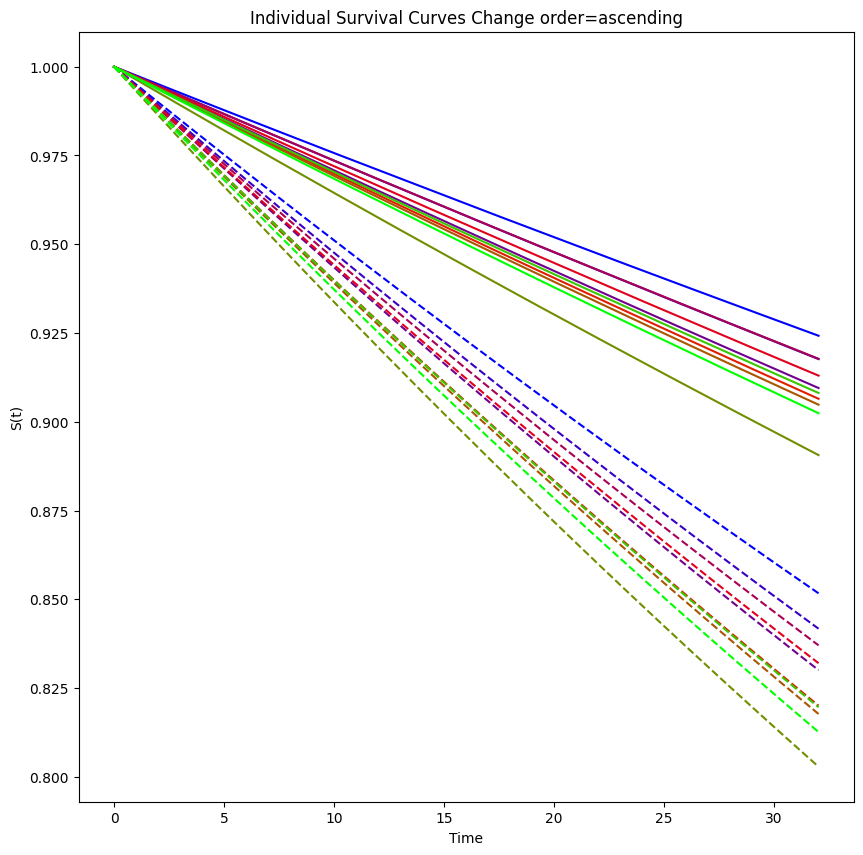

In [23]:
eps = 0.3
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_train,epsilon=eps,order="ascending",test_cases=10)

visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="descending")
visualize_individual_curves_attacked(clf_robust,dataloader_test,epsilon=eps,order="ascending")